In [1]:
# formats the data from BillBoard to be Queried with the Genius API

def fArtist(artist):
    a = splitFeature(artist)
    a = splitAND(a)
    a = splitComma(a)
    return a.strip()

def splitFeature(artist):
    head, sep, tail = artist.partition('Featuring')
    return head

def splitAND(artist):
    head, sep, tail = artist.partition('&')
    return head

def splitComma(artist):
    head, sep, tail = artist.partition(',')
    return head


In [2]:
import pandas as pd
import pymysql
import json
import sklearn
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
years = ['1956', '1957', '1958', '1959', '1960',
         '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970',
        '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980',
        '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990',
        '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000',
        '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
        '2011', '2012', '2013', '2014', '2015']

#initialize charts, which contains each year's hot 100 charts
charts = {}
# initialize the data for all the years 
for year in years:
    charts[year] = pd.read_csv('~/Downloads/billboard/' + year + '.csv')
    if 'PositionÊ' in charts.get(year).columns:
        charts[year] = charts[year].rename(columns={"PositionÊ": "Position"})
    charts[year]['Lyrics'] = ""
    


#Connect To MYSQL Database and Genius API

conn = pymysql.connect( host='localhost', user='root', passwd="Ishaaniscool!", db= "Music")
current = conn.cursor() 
genius = lyricsgenius.Genius("2URYv5lLVxhEyIsydOwwAmbp6ZoMEO7v-MM4LKI--ih0xTGCWu9lJjHNpx0AdjA-")

Below is the MarkDown Script for Extracting Lyrics and saving to MySQL Database. Because of server timeouts by the Genius API, a commit was made as soon as a full year's worth of Music Lyrics was saved. This was repeated until every year's worth of BillBoard data was populated in the Database.



for year in years:
    df = charts.get(year)
    for index, row in df.iterrows():
        song = genius.search_song(row['Song Title'], fArtist(row['Artist']))
        if song is not None:
            #row['Lyrics'] = song.lyrics
            query = "INSERT INTO Music_Archive(Title, Artist, Year, Position, Lyrics) VALUES (%s, %s, %s, %s, %s)"
            current.execute(query, (song.artist, song.title, int(year), int(row['Position']), song.lyrics))
    conn.commit()

conn.close()   


 The Database itself contains one table with the BillBoard Year, the Title, Artist, BillBoard Position, and Lyrics. The Primary Key for this table was the Year and Title (given it is possible a song extends multiple years)

Cleaning Data in MYSQLWorkBench:

First, need to get rid of songs that have over 7,000 characters or contains BillBoard/Genius in its Title because it is likely incorrect data outputted by the Genius Query

Delete from Music_Archive where length(Lyrics) > 10000

Delete from Music_Archive where Title = 'Billboard'

Delete from Music_Archive where Title = 'Genius'

SELECT * FROM Music_Archive WHERE Title LIKE '%Screen Genius%'

SELECT * FROM Music_Archive WHERE Title LIKE '%Genius%'

Lastly, there was too little relevant Lyrics data from 1950 - 1955 so I dropped all the rows from these years. I Guess we are working with data after 1955.

Delete from Music_Archive where Year < 1956

In [3]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim import corpora, models
import gensim
from nltk.stem import SnowballStemmer
from gensim.models import LdaModel, LdaMulticore
import re
from sklearn.feature_extraction.text import TfidfVectorizer


# load the JSON file from the cleaned Database
data = pd.read_json(r'/Users/rohiljaveri/Downloads/FinalLyrics.json')

#lowercase all the lyrics
data['Lyrics'] = data['Lyrics'].str.lower()

def removeNestedParentheses(s):
    ret = ''
    skip = 0
    for i in s:
        if i == '[':
            skip += 1
        elif i == ']'and skip > 0:
            skip -= 1
        elif skip == 0:
            ret += i
    return ret

words = set(nltk.corpus.words.words())

#get rid of shit in between brackets
for i, row in data.iterrows():
    data.at[i,'Lyrics'] = removeNestedParentheses(data.at[i,'Lyrics'])
    data.at[i,'Lyrics'] = " ".join(w for w in nltk.wordpunct_tokenize(data.at[i,'Lyrics']) \
        if w.lower() in words or not w.isalpha())
        



#get rid of tracks that are empty
data = data[data['Lyrics'] != ""]




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohiljaveri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
#this model was a poor approach at determining topics because of the number 

stopwordscustom = ['yeah', 'oo', 'ooo', 'ooh', 'oh', 'woah', 'feat', 'aye', 'la', 'hey', 'doo',
                   'ye', 'bomp', 'instrumental', 'Instrumental', ']', '[', 'Chorus', 'Verse', "huh"
                   'Intro', ':', '\n', 'cause'] 
#set the stop_words
stop_words = set(stopwords.words('english')) 

#Create SnowBallStemmer
snowball = SnowballStemmer(language='english')

# list for tokenized documents in loop
texts = []

for index, row in data.iterrows():
    tokens = tokenizer.tokenize(row['Lyrics'])
    
    #remove non-nouns
    tagged = nltk.pos_tag(tokens)
    tagged = [s for s in tagged if s[1] == 'NN']
    tagged_tokens = [s[0] for s in tagged]

    
    stopped = [i for i in tagged_tokens if not i in stop_words]
    stopped = [i for i in stopped if not i in stopwordscustom]
    stopped = [i for i in stopped if len(i) > 2]
    stemmed = [snowball.stem(i) for i in stopped]
    texts.append(stopped)
    
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
print(dictionary)

# convert tokenized documents into a document-term matrix
bow_corpus = [dictionary.doc2bow(text) for text in texts]

#
tfidf = models.TfidfModel(bow_corpus, normalize = True)
corpus_tfidf = tfidf[bow_corpus]

#print(corpus_tfidf)
# generate LDA model
lda_model_tfidf = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics= 2, iterations = 100, id2word = dictionary, passes= 20)

Dictionary(7544 unique tokens: ['baby', 'bellhop', 'clerk', 'desk', 'end']...)


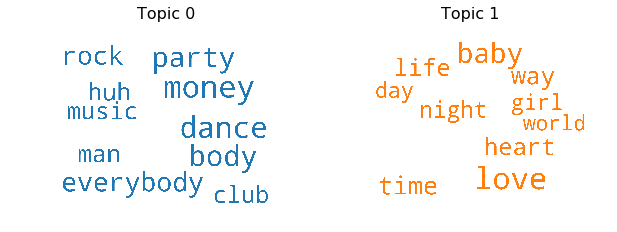

In [37]:
#visualize the  information lol
#source from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_tfidf.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')



# the next step of this project is sentiment analysis... first I'm going to download data the has labels for positive/negative lyrics


Code to Download the Training data to the database

import pandas as pd
import pylyrics3
import pymysql
conn = pymysql.connect( host='localhost', user='root', passwd="Ishaaniscool!", db= "Music")
current = conn.cursor() 

#row['Lyrics'] = song.lyrics
#1062

pd.options.display.max_columns = 999
X = pd.read_csv(r'/Users/rohiljaveri/Downloads/ml_pn_balanced.csv')
X = X.drop(['Index'], axis=1)

#250, 486

for index, row in X.iterrows():
        lyrics = pylyrics3.get_song_lyrics(row['Artist'], row['Title'])
        if lyrics is not None:
            print(index)
            query = "INSERT INTO Label_Songs(Title, Artist, Lyrics, Label) VALUES (%s, %s, %s, %s)"
            current.execute(query, (row['Title'], row['Artist'], lyrics, row['Mood']))
            conn.commit()

conn.close()   


Had to go in and manually enter the data that had no lyrics searched

In [6]:
import pandas as pd 
import numpy as np
# load the JSON file from the cleaned Database
NNdata = pd.read_json(r'/Users/rohiljaveri/Downloads/TrainData.json')

#lowercase all the lyrics
NNdata['Lyrics'] = NNdata['Lyrics'].str.lower()


words = set(nltk.corpus.words.words())

#get rid of shit in between brackets
for i, row in NNdata.iterrows():
    NNdata.at[i,'Lyrics'] = removeNestedParentheses(NNdata.at[i,'Lyrics'])
    NNdata.at[i,'Lyrics'] = " ".join(w for w in nltk.wordpunct_tokenize(NNdata.at[i,'Lyrics']) \
        if w.lower() in words or not w.isalpha())
        

#get rid of tracks that are empty
NNdata = NNdata[NNdata['Lyrics'] != ""]


In [7]:
#preprocess the labelled data
def preprocess(X):
    tokens = tokenizer.tokenize(X)
    stopped = [i for i in tokens if not i in stop_words]
    stopped = [i for i in stopped if not i in stopwordscustom]
    stopped = [i for i in stopped if len(i) > 2]
    stemmed = [snowball.stem(i) for i in stopped]
    processed = ' '.join(stemmed)
    return processed





In [8]:
#in the test data, turn "neg" into 0 and "pos" into 1
for index, row in NNdata.iterrows():
    if row['Label'] == 'neg':
        row['Label'] = 0
    else:
        row['Label'] = 1

In [9]:
from sklearn.model_selection import train_test_split
#splits into Series for train and test values
X_train, X_test, y_train, y_test = train_test_split(NNdata['Lyrics'], NNdata['Label'], test_size=0.20, random_state=42)

y_test = np.asarray(y_test)
y_train = np.asarray(y_train)
y_train = y_train.astype('int') 
y_test = y_test.astype('int') 

y_train = y_train.flatten()
y_test = y_test.flatten()


X_train = X_train.apply(lambda x: preprocess(x))
X_test = X_test.apply(lambda x: preprocess(x))


#fit the training data to the vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf_matrix = vectorizer.fit_transform(X_train)

#transform the test data to the test data
X_test_tfidf_matrix = vectorizer.transform(X_test)

print(X_train_tfidf_matrix.shape)
print(X_test_tfidf_matrix.shape)


# number of words in the matrix
#n_words = X_test_tfidf_matrix.shape[1]

(1552, 55250)
(389, 55250)


In [10]:
# print(y_train)
# X_train_tfidf_matrix=X_train_tfidf_matrix.toarray()


In [11]:
# Our vectorized labels
#y_train = np.asarray(y_train).astype('float32').reshape((-1, 1))
#y_test = np.asarray(y_test).astype('float32').reshape((-1, 1))

In [35]:
seed = 7
import tensorflow as tf
import tensorflow.compat.v1 as tf
np.random.seed(seed)

with tf.variable_scope("test"):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.preprocessing import sequence

            
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='relu'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


print(y_train)


model.fit(X_train_tfidf_matrix.todense(), y_train, epochs= 20, verbose=2)

[1 0 1 ... 0 1 1]
Train on 1552 samples
Epoch 1/20
1552/1552 - 1s - loss: 1.3958 - accuracy: 0.5026
Epoch 2/20
1552/1552 - 1s - loss: 0.5782 - accuracy: 0.5322
Epoch 3/20
1552/1552 - 1s - loss: 0.3081 - accuracy: 0.8431
Epoch 4/20
1552/1552 - 1s - loss: 0.1195 - accuracy: 0.9791
Epoch 5/20
1552/1552 - 1s - loss: 0.0398 - accuracy: 0.9971
Epoch 6/20
1552/1552 - 1s - loss: 0.0170 - accuracy: 0.9994
Epoch 7/20
1552/1552 - 1s - loss: 0.0089 - accuracy: 0.9994
Epoch 8/20
1552/1552 - 1s - loss: 0.0052 - accuracy: 0.9997
Epoch 9/20
1552/1552 - 1s - loss: 0.0033 - accuracy: 1.0000
Epoch 10/20
1552/1552 - 1s - loss: 0.0022 - accuracy: 1.0000
Epoch 11/20
1552/1552 - 1s - loss: 0.0016 - accuracy: 1.0000
Epoch 12/20
1552/1552 - 1s - loss: 0.0012 - accuracy: 1.0000
Epoch 13/20
1552/1552 - 0s - loss: 8.9697e-04 - accuracy: 1.0000
Epoch 14/20
1552/1552 - 1s - loss: 7.0396e-04 - accuracy: 1.0000
Epoch 15/20
1552/1552 - 0s - loss: 5.5476e-04 - accuracy: 1.0000
Epoch 16/20
1552/1552 - 1s - loss: 4.4256e

In [32]:
# evaluate
loss, acc = model.evaluate(X_test_tfidf_matrix.todense(), y_test, verbose=2)
print('Test Accuracy: %f' % (acc*100))


389/389 - 0s - loss: 0.3097 - accuracy: 0.8496
Test Accuracy: 84.961438


In [40]:
# make predictions on the BillBoard data 
X_prediction = data['Lyrics'].apply(lambda x: preprocess(x))
prediction_matrix = vectorizer.transform(X_prediction)
predictions = model.predict(prediction_matrix.todense(), verbose = 2)

# 0 = negative, 1 = positive
labels = []
for p in predictions:
    labels.append(np.argmax(p))
    
data['Labels'] = labels
    

5451/5451 - 1s
                                                 Artist                                             Lyrics  Position                                              Title  Year  Labels
0                                      Heartbreak Hotel  well , since my baby left me well , i found a ...         1                                      Elvis Presley  1956       0
1                                        Don’t Be Cruel  you know i can be found sitting home all alone...         2                                      Elvis Presley  1956       1
2                                        Lisbon Antigua  i gave my heart to you in old that night under...         3                                      Nelson Riddle  1956       1
3                                             My Prayer  when the twilight is gone and no are singing w...         4                                       The Platters  1956       1
4                                      The Wayward Wind  the wayward wind i

In [42]:
## find the number of negative and positive values in the new data
print(data['Labels'].value_counts())

0    3222
1    2229
Name: Labels, dtype: int64


In [55]:
# find the change over time of positivity/negativity in the music
yearData = data.groupby(['Year']).mean()
print(yearData.index.to)

Index(['Position', 'Labels'], dtype='object')


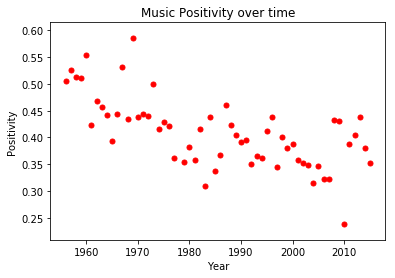

In [61]:
import matplotlib as plt

import matplotlib.pyplot as plt

plt.scatter(yearData.index.tolist(), yearData['Labels'].tolist(), color='red', s=25, marker="o")
plt.xlabel('Year')
plt.ylabel('Positivity')
plt.title('Music Positivity over time')
plt.show()